In [61]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
from scipy import linalg
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [62]:
# Function to load NVIDIA data from exported files
def load_nvidia_data(base_dir='data'):
    """
    Parameters:
        base_dir : Base directory where data files are stored
    
    Returns:
        Dictionary containing loaded data
    """
    # Defines directory paths
    csv_dir = f'{base_dir}'
    train_dir = f'{base_dir}/npy/train'
    test_dir = f'{base_dir}/npy/test'
    
    # Loads CSV data
    technical_data = pd.read_csv(f'{csv_dir}/nvidia_technical_data.csv', index_col=0, parse_dates=True, date_format="%d/%m/%Y")
    normalized_data = pd.read_csv(f'{csv_dir}/nvidia_normalized_data.csv', index_col=0, parse_dates=True, date_format="%d/%m/%Y")
    ceflann_data = pd.read_csv(f'{csv_dir}/nvidia_ceflann_data.csv', index_col=0, parse_dates=True, date_format="%d/%m/%Y")
    
    # Loads NumPy arrays for training and testing
    X_train = np.load(f'{train_dir}/nvidia_X_train.npy')
    y_train = np.load(f'{train_dir}/nvidia_y_train.npy')
    train_dates = np.load(f'{train_dir}/nvidia_train_dates.npy', allow_pickle=True)
    train_prices = np.load(f'{train_dir}/nvidia_train_price_data.npy')
    
    # Loads main test data
    X_test = np.load(f'{test_dir}/nvidia_X_test.npy')
    y_test = np.load(f'{test_dir}/nvidia_y_test.npy')
    test_dates = np.load(f'{test_dir}/nvidia_test_dates.npy', allow_pickle=True)
    test_prices = np.load(f'{test_dir}/nvidia_price_data.npy')
    
    # Tries to load multiple test weeks if available
    test_weeks = []
    test_weeks_info = np.load(f'{base_dir}/npy/nvidia_test_weeks_info.npy', allow_pickle=True)
    
    # Loads each test week
    for i in range(len(test_weeks_info)):
        try:
            week_data = {
                'X': np.load(f'{test_dir}/nvidia_X_test_week_{i}.npy'),
                'y': np.load(f'{test_dir}/nvidia_y_test_week_{i}.npy'),
                'dates': np.load(f'{test_dir}/nvidia_test_dates_week_{i}.npy', allow_pickle=True),
                'prices': np.load(f'{test_dir}/nvidia_price_data_week_{i}.npy'),
                'info': test_weeks_info[i]
            }
            test_weeks.append(week_data)
        except Exception as e:
            print(f"Warning: Could not load test week {i}: {e}")
    
    # Loads latest info
    with open(f'{csv_dir}/nvidia_info.txt', 'r') as f:
        latest_info = f.read().split(',')
        latest_date = latest_info[0]
        latest_close = float(latest_info[1])
        test_week_length = int(latest_info[2]) if len(latest_info) > 2 else 5
        num_test_weeks = int(latest_info[3]) if len(latest_info) > 3 else 0
    
    return {
        'technical_data': technical_data,
        'normalized_data': normalized_data,
        'ceflann_data': ceflann_data,
        'X_train': X_train,
        'y_train': y_train,
        'train_dates': train_dates,
        'train_prices': train_prices,
        'X_test': X_test,
        'y_test': y_test,
        'test_dates': test_dates,
        'test_prices': test_prices,
        'test_weeks': test_weeks,
        'test_weeks_info': test_weeks_info,
        'latest_date': latest_date,
        'latest_close': latest_close,
        'test_week_length': test_week_length,
        'num_test_weeks': num_test_weeks
    }

In [63]:
# Load all NVIDIA data
nvidia_data = load_nvidia_data()

# Print summary of loaded data
print(f"Latest date: {nvidia_data['latest_date']}")
print(f"Latest NVIDIA close price: ${nvidia_data['latest_close']:.2f}")
print(f"Training data shape: X={nvidia_data['X_train'].shape}, y={nvidia_data['y_train'].shape}")
print(f"Testing data shape: X={nvidia_data['X_test'].shape}, y={nvidia_data['y_test'].shape}")
print(f"Number of test weeks: {len(nvidia_data['test_weeks'])}")

Latest date: 2025-03-14 00:00:00
Latest NVIDIA close price: $121.67
Training data shape: X=(1031, 6), y=(1031,)
Testing data shape: X=(5, 6), y=(5,)
Number of test weeks: 54


In [64]:
class CEFLANN:
    """
    The Computational Efficient Functional Link Artificial Neural Network model
    
    The implementation is based on "A hybrid stock trading framework integrating 
    technical analysis with machine learning techniques" by Dash & Dash (2016)
    """
    
    def __init__(self, expansion_order=5, regularization=0.01):
        """
        Parameters:
            expansion_order(int) : The order of expansion for the functional expansion block
            regularization(float) : Regularization parameter for the ELM learning
        """
        self.expansion_order = expansion_order
        self.regularization = regularization
        self.output_weights = None
        self.expansion_params = None
        
    def _functional_expansion(self, X):
        """
        Parameters:
            X : Input feature matrix with shape (n_samples, n_features)
            
        Returns:
            expanded_X : Expanded input pattern array
        """
        n_samples, n_features = X.shape
        
        # Number of expanded features = original features + expansion order
        n_expanded = n_features + self.expansion_order
        
        # Initializes the expanded feature matrix
        expanded_X = np.zeros((n_samples, n_expanded))
        expanded_X[:, :n_features] = X
        
        
        if self.expansion_params is None:
            # For each order i, initializes parameters a_i0 and a_ij (j is from 1 to n_features)
            self.expansion_params = []
            for i in range(self.expansion_order):
                # Initialize bias term a_i0
                a_i0 = np.random.uniform(-1, 1)
                
                # Initialize weights a_ij for each feature
                a_ij = np.random.uniform(-1, 1, size=n_features)
                
                self.expansion_params.append((a_i0, a_ij))
        
        # Applies functional expansion for each order
        for i in range(self.expansion_order):
            a_i0, a_ij = self.expansion_params[i]
            
            # Calculates weighted sum of input features
            weighted_sum = a_i0 + np.dot(X, a_ij)
            
            # Applies a tanh activation function
            expanded_X[:, n_features + i] = np.tanh(weighted_sum)
            
        return expanded_X
    
    def fit(self, X, y):
        """
        Parameters:
            X : Training feature matrix of shape (n_samples, n_features)
            y : Target values array of shape (n_samples,)
            
        Returns:
            self : Returns self
        """
        # Applies functional expansion to transform input features
        expanded_X = self._functional_expansion(X)
        
        # Adds the bias to the expanded input
        n_samples = expanded_X.shape[0]
        bias_col = np.ones((n_samples, 1))
        M = np.hstack((bias_col, expanded_X))
        
        # Uses regularized least squares (Ridge Regression) for output weights        
        n_cols = M.shape[1]
        MtM = np.dot(M.T, M)
        reg_term = self.regularization * np.eye(n_cols)
        inverse_term = np.linalg.inv(MtM + reg_term)
        MP_inverse = np.dot(inverse_term, M.T)
        
        # Calculates output weights
        self.output_weights = np.dot(MP_inverse, y)
        
        return self
    
    def predict(self, X):
        """
        Parameters:
            X : Test feature matrix of shape (n_samples, n_features)
            
        Returns:
            y_pred : Array of predicted values
        """
        # Applies functional expansion to transform input features
        expanded_X = self._functional_expansion(X)
        
        # Adds bias to expanded input
        n_samples = expanded_X.shape[0]
        bias_col = np.ones((n_samples, 1))
        M = np.hstack((bias_col, expanded_X))
        
        y_pred = np.dot(M, self.output_weights)
        
        return y_pred
    
    def evaluate(self, X, y):
        """
        Parameters:
            X : Test feature matrix array
            y : Target values array
            
        Returns:
            metrics : Dictionary containing evaluation metrics
        """
        y_pred = self.predict(X)
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        
        return {
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'rmse': np.sqrt(mse),
            'predictions': y_pred
        }
    
    # Save model parameters to a file
    def save(self, filename):
        
        if self.output_weights is None:
            raise ValueError("The model isn't trained yet")
        
        model_params = {
            'expansion_order': self.expansion_order,
            'regularization': self.regularization,
            'output_weights': self.output_weights,
            'expansion_params': self.expansion_params
        }
        
        np.save(filename, model_params)
        
    #Load model parameters from a file
    def load(self, filename):
        
        model_params = np.load(filename, allow_pickle=True).item()
        
        self.expansion_order = model_params['expansion_order']
        self.regularization = model_params['regularization']
        self.output_weights = model_params['output_weights']
        self.expansion_params = model_params['expansion_params']
        
        return self

In [65]:
# Training functions for CEFLANN model with hyperparameter selection

def train_model(X_train, y_train, expansion_order=5, regularization=0.01):
    """
        
    Parameters:
        X_train : Training features
        y_train : Training targets
        expansion_order : Order of expansion for functional expansion block
        regularization : Regularization parameter for ELM learning
    
    Returns:
        model : Trained CEFLANN model
        training_time : Time taken to train the model
    """
    model = CEFLANN(expansion_order=expansion_order, regularization=regularization)
    
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    return model, training_time

In [66]:
# Tunes optimal hyperparameters for the CEFLANN model
def find_best_hyperparameters(X_train, y_train, X_val, y_val, expansion_orders=[3, 5, 7], 
                              regularizations=[0.001, 0.01, 0.1, 1.0]):
    """
    Parameters:
        X_train : Training features
        y_train : Training targets
        X_val : Validation features
        y_val : Validation targets
        expansion_orders : List of expansion orders to try
        regularizations : List of regularization parameters to try
    
    Returns:
        best_params : Dictionary containing best parameters
        results : DataFrame containing all results
    """
    results = []
    
    best_mse = float('inf')
    best_params = {}
    
    for order in expansion_orders:
        for reg in regularizations:
            model, train_time = train_model(X_train, y_train, order, reg)
            
            # Evaluate on validation set
            metrics = model.evaluate(X_val, y_val)
            
            result = {
                'expansion_order': order,
                'regularization': reg,
                'train_time': train_time,
                'mse': metrics['mse'],
                'rmse': metrics['rmse'],
                'r2': metrics['r2'],
                'mae': metrics['mae']
            }
            
            results.append(result)
            
            # Update best parameters if needed
            if metrics['mse'] < best_mse:
                best_mse = metrics['mse']
                best_params = {
                    'expansion_order': order,
                    'regularization': reg
                }
    
    
    results_df = pd.DataFrame(results)
    
    return best_params, results_df

In [67]:
# Function to train and evaluate the final model
def train_final_model(X_train, y_train, X_test, y_test, params=None):
    """
    Parameters:
        X_train : Training features
        y_train : Training targets
        X_test : Test features
        y_test : Test targets
        params : Dictionary of parameters (if None, use defaults)
    
    Returns:
        model : Trained model
        metrics : Dictionary of evaluation metrics
    """
    if params is None:
        expansion_order = 5
        regularization = 0.01
    else:
        expansion_order = params.get('expansion_order', 5)
        regularization = params.get('regularization', 0.01)
    
    model, train_time = train_model(X_train, y_train, expansion_order, regularization)
    
    # Evaluate on test set
    metrics = model.evaluate(X_test, y_test)
    metrics['train_time'] = train_time
    
    return model, metrics

In [68]:
# Trading decision system based on CEFLANN predictions and the the Dash & Dash (2016) paper
# Implements signal processing and trading rules for the CEFLANN model
class TradingDecisionSystem:
        
    def __init__(self, signal_threshold=0.5):
        """
        Parameters:
            signal_threshold : Threshold to classify signals (default: 0.5)
        """
        self.signal_threshold = signal_threshold
        
    def classify_trends(self, trading_signals):
        """
        Parameters:
            trading_signals : Array of trading signals (0-1 range)
        
        Returns:
            trends : Array of trend classifications (1 for uptrend, 0 for downtrend)
        """
        # Compare with threshold to determine trend
        trends = np.where(trading_signals > self.signal_threshold, 1, 0)
        return trends
    
    def generate_trading_decisions(self, trends):
        """
        
        Parameters:
            trends : Array of trend classifications
        
        Returns:
            decisions : Array of trading decisions (1: Buy, 0: Hold, -1: Sell)
        """
        decisions = np.zeros(len(trends), dtype=int)
        
        # Initialize with HOLD
        decisions.fill(0)
        
        # First decision can't be based on previous state
        if trends[0] == 1:
            decisions[0] = 1  # BUY
        
        # Apply trading rules from the paper
        for i in range(1, len(trends)):
            # If current trend is up and previous trend was down -> BUY
            if trends[i] == 1 and trends[i-1] == 0:
                decisions[i] = 1  # BUY
            
            # If current trend is down and previous trend was up -> SELL
            elif trends[i] == 0 and trends[i-1] == 1:
                decisions[i] = -1  # SELL
        
        return decisions
    
    def get_trading_decisions(self, model_predictions):
        """
        Parameters:
            model_predictions : Array of model predictions (trading signals)
        
        Returns:
            decisions : Array of trading decisions (1: Buy, 0: Hold, -1: Sell)
            trends : Array of trend classifications
        """
        
        trends = self.classify_trends(model_predictions)
        decisions = self.generate_trading_decisions(trends)
        
        return decisions, trends
    
    def interpret_decision(self, decision):
        """
        Parameters:
            decision : Numeric decision (1: Buy, 0: Hold, -1: Sell)
        
        Returns:
            A string representation of the decision (Buy/Sell/Hold)
        """
        if decision == 1:
            return "BUY"
        elif decision == -1:
            return "SELL"
        else:
            return "HOLD"

In [69]:
# Simulation Environment for Trading
# Simulates a trading scenario with initial capital, transaction costs, and portfolio tracking.
class TradingSimulation:
    
    def __init__(self, port=10000, transaction_fee=0.01):
        """
        Parameters:
            port : Initial portfolio value in USD
            transaction_fee : Transaction fee percentage (0.01 = 1%)
        """
        self.port = port
        self.transaction_fee = transaction_fee
        
        # Initialize portfolio
        self.reset()
    
    def reset(self):
        """Reset the simulation to initial state"""
        self.cash = self.port
        self.shares = 0
        self.transactions = []
        self.portfolio_values = []
        self.current_day = 0
    
    def execute_order(self, decision, price, day, amount=None, shares=None):
        """
        Parameters:
            decision : Trading decision (BUY, SELL, HOLD)
            price : Current stock price
            day : Current trading day
            amount : Amount to invest when buying (USD)
            shares : Number of shares to sell when selling
        
        Returns:
            transaction : Dictionary containing transaction details
        """
        transaction = {
            'day': day,
            'decision': decision,
            'price': price,
            'pre_cash': self.cash,
            'pre_shares': self.shares,
            'fees': 0
        }
        
        if decision == "BUY":
            # Determine amount to invest
            if amount is None:
                # Use all available cash if amount not specified
                amount = self.cash
            
            # Calculate fees
            fee = amount * self.transaction_fee
            
            # Calculate shares to buy
            affordable_amount = amount - fee
            new_shares = affordable_amount / price
            
            # Update portfolio
            if affordable_amount > 0:
                self.cash -= amount
                self.shares += new_shares
                
                transaction['amount'] = amount
                transaction['fees'] = fee
                transaction['shares_bought'] = new_shares
            else:
                transaction['status'] = "INSUFFICIENT_FUNDS"
                return transaction
                
        elif decision == "SELL":
            # Determine shares to sell
            if shares is None:
                # Sell all shares if not specified
                shares = self.shares
            
            # Calculate proceeds
            proceeds = shares * price
            
            # Calculate fees
            fee = proceeds * self.transaction_fee
            
            # Update portfolio
            if shares > 0:
                self.shares -= shares
                self.cash += (proceeds - fee)
                
                transaction['shares_sold'] = shares
                transaction['proceeds'] = proceeds
                transaction['fees'] = fee
            else:
                transaction['status'] = "NO_SHARES"
                return transaction
        
        # Update transaction with final portfolio state
        transaction['post_cash'] = self.cash
        transaction['post_shares'] = self.shares
        transaction['portfolio_value'] = self.cash + (self.shares * price)
        transaction['status'] = "EXECUTED"
        
        # Record the transaction
        self.transactions.append(transaction)
        self.portfolio_values.append(transaction['portfolio_value'])
        self.current_day += 1
        
        return transaction
    
    def simulate_trading_period(self, decisions, prices, dates=None):
        """
        Parameters:
            decisions : List of trading decisions (BUY, SELL, HOLD)
            prices : List of stock prices for each day
            dates : List of dates (optional)
        
        Returns:
            results : Dictionary containing simulation results
        """
        # Reset the simulation
        self.reset()
        
        # Ensure decisions and prices have the same length
        assert len(decisions) == len(prices), "Decisions and prices must have the same length"
        
        # Use integer indices if dates not provided
        if dates is None:
            dates = list(range(len(decisions)))
        
        # Execute each decision
        daily_results = []
        
        for i, (decision, price, date) in enumerate(zip(decisions, prices, dates)):
            # Determine amount/shares based on decision
            amount = None
            shares = None
            
            if decision == "BUY":
                # Use all available cash
                amount = self.cash
            elif decision == "SELL":
                # Sell all shares
                shares = self.shares
            
            # Execute the order
            transaction = self.execute_order(decision, price, date, amount, shares)
            daily_results.append(transaction)
        
        # Calculate performance metrics
        initial_value = self.port
        final_value = self.portfolio_values[-1] if self.portfolio_values else initial_value
        
        profit = final_value - initial_value
        profit_percent = (profit / initial_value) * 100
        
        # Calculate number of trades
        buys = sum(1 for t in self.transactions if t['decision'] == "BUY" and t['status'] == "EXECUTED")
        sells = sum(1 for t in self.transactions if t['decision'] == "SELL" and t['status'] == "EXECUTED")
        
        # Calculate total fees
        total_fees = sum(t['fees'] for t in self.transactions if 'fees' in t)
        
        # Prepare results
        results = {
            'initial_value': initial_value,
            'final_value': final_value,
            'profit': profit,
            'profit_percent': profit_percent,
            'total_fees': total_fees,
            'num_buys': buys,
            'num_sells': sells,
            'transactions': self.transactions,
            'portfolio_values': self.portfolio_values,
            'daily_results': daily_results
        }
        
        return results

In [70]:
# Order Generation System

class OrderGenerator:
    """
    Order Generator System
    
    Generates formatted orders for the trading simulation based on 
    model predictions and trading decisions.
    """
    
    def __init__(self, simulation):
        """
        Parameters:
            simulation : TradingSimulation instance
        """
        self.simulation = simulation
    
    def generate_order(self, decision, price, portfolio_value, cash, shares):
        """
        Parameters:
            decision : Trading decision (BUY, SELL, HOLD)
            price : Current stock price
            portfolio_value : Current portfolio value
            cash : Available cash
            shares : Current shares held
        
        Returns:
            order : Formatted order string
            order_details : Dictionary with order details
        """
        order_details = {
            'decision': decision,
            'price': price,
            'portfolio_value': portfolio_value,
            'cash': cash,
            'shares': shares
        }
        
        
        if decision == "BUY":
            # Buy order specifies dollar amount
            amount = cash  # Use all available cash
            order = f"Buy: ${amount:.2f}"
            order_details['amount'] = amount
            
        elif decision == "SELL":
            # Sell order specifies number of shares
            num_shares = shares  # Sell all shares
            order = f"Sell: {num_shares:.6f} shares"
            order_details['num_shares'] = num_shares
            
        else:  # HOLD
            order = "Hold"
        
        return order, order_details
    
    def generate_orders_for_week(self, model, decision_system, features, prices, dates=None):
        """
        Parameters:
            model : Trained CEFLANN model
            decision_system : TradingDecisionSystem instance
            features : Technical indicators for the week
            prices : Stock prices for the week
            dates : Dates for the week (optional)
        
        Returns:
            orders : List of formatted orders
            simulation_results : Results from the simulation
        """
        # Make predictions using the model
        predictions = model.predict(features)
        
        # Convert predictions to trading decisions
        numeric_decisions, trends = decision_system.get_trading_decisions(predictions)
        
        # Convert numeric decisions to string representations
        string_decisions = [decision_system.interpret_decision(d) for d in numeric_decisions]
        
        # Simulate trading for the week
        simulation_results = self.simulation.simulate_trading_period(
            string_decisions, prices, dates
        )
        
        # Generate formatted orders
        orders = []
        order_details = []
        
        # Reset simulation to generate orders
        self.simulation.reset()
        
        cash = self.simulation.cash
        shares = self.simulation.shares
        
        for i, (decision, price) in enumerate(zip(string_decisions, prices)):
            portfolio_value = cash + (shares * price)
            
            # Generate order
            order, details = self.generate_order(
                decision, price, portfolio_value, cash, shares
            )
            
            orders.append(order)
            order_details.append(details)
            
            # Update portfolio for next day's order
            if decision == "BUY":
                # Calculate shares bought minus fees
                amount = cash
                fee = amount * self.simulation.transaction_fee
                affordable_amount = amount - fee
                new_shares = affordable_amount / price
                
                cash = 0
                shares += new_shares
                
            elif decision == "SELL":
                # Calculate proceeds minus fees
                proceeds = shares * price
                fee = proceeds * self.simulation.transaction_fee
                net_proceeds = proceeds - fee
                
                cash += net_proceeds
                shares = 0
        
        return orders, order_details, simulation_results

In [71]:
# Complete prediction and trading pipeline

def run_trading_pipeline(X_train, y_train, X_test, y_test, test_prices, test_dates=None, expansion_order=5, regularization=0.01):
    """
    Parameters:
        X_train : Training features
        y_train : Training targets
        X_test : Test features (for the simulation week)
        y_test : Test targets (for evaluation)
        test_prices : Stock prices for the test period
        test_dates : Dates for the test period (optional)
        expansion_order : Expansion order for CEFLANN
        regularization : Regularization parameter for CEFLANN
    
    Returns:
        results : Dictionary containing all results
    """
    # 1. Train the CEFLANN model
    model, train_time = train_model(X_train, y_train, expansion_order, regularization)
    
    # 2. Make predictions
    test_predictions = model.predict(X_test)
    
    # 3. Evaluate prediction accuracy
    metrics = model.evaluate(X_test, y_test)
    
    # 4. Create trading decision system (references cell [8])
    decision_system = TradingDecisionSystem()
    
    # 5. Get trading decisions
    decisions, trends = decision_system.get_trading_decisions(test_predictions)
    string_decisions = [decision_system.interpret_decision(d) for d in decisions]
    
    # 6. Set up simulation environment (references cell [9])
    simulation = TradingSimulation(port=10000, transaction_fee=0.01)
    
    # 7. Run simulation
    simulation_results = simulation.simulate_trading_period(string_decisions, test_prices, test_dates)
    
    # 8. Generate orders (references cell [10])
    order_generator = OrderGenerator(simulation)
    orders, order_details, _ = order_generator.generate_orders_for_week(
        model, decision_system, X_test, test_prices, test_dates
    )
    
    # Compile all results
    results = {
        'model': model,
        'training_time': train_time,
        'evaluation_metrics': metrics,
        'predictions': test_predictions,
        'decisions': string_decisions,
        'trends': trends,
        'simulation_results': simulation_results,
        'orders': orders,
        'order_details': order_details
    }
    
    return results

In [72]:
# Plot chart of predictions vs. real prices

def plot_predictions_vs_actual(predictions, actual, dates=None, title="Model Predictions vs Actual Prices"):
    """Plot predictions against actual values"""
    plt.figure(figsize=(12, 6))
    
    if dates is None:
        x = range(len(predictions))
    else:
        x = dates
    
    plt.plot(x, predictions, 'b-', label='Predicted')
    plt.plot(x, actual, 'r-', label='Actual')
    
    plt.title(title)
    plt.xlabel('Date' if dates is not None else 'Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if dates is not None:
        plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

In [73]:
def plot_portfolio_performance(simulation_results, dates=None, title="Portfolio Performance"):
    plt.figure(figsize=(12, 6))
    
    if dates is None:
        x = range(len(simulation_results['portfolio_values']))
    else:
        x = dates
    
    plt.plot(x, simulation_results['portfolio_values'], 'g-', linewidth=2)
    
    # Mark buy and sell points
    buys = [(i, t['portfolio_value']) for i, t in enumerate(simulation_results['transactions']) 
            if t['decision'] == 'BUY' and t['status'] == 'EXECUTED']
    sells = [(i, t['portfolio_value']) for i, t in enumerate(simulation_results['transactions']) 
             if t['decision'] == 'SELL' and t['status'] == 'EXECUTED']
    
    if buys:
        buy_x, buy_y = zip(*buys)
        if dates is not None:
            buy_x = [dates[i] for i in buy_x]
        plt.scatter(buy_x, buy_y, color='blue', marker='^', s=100, label='Buy')
    
    if sells:
        sell_x, sell_y = zip(*sells)
        if dates is not None:
            sell_x = [dates[i] for i in sell_x]
        plt.scatter(sell_x, sell_y, color='red', marker='v', s=100, label='Sell')
    
    plt.title(title)
    plt.xlabel('Date' if dates is not None else 'Day')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if dates is not None:
        plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

In [74]:
def display_trading_summary(results):
    sim_results = results['simulation_results']
    
    print("===== TRADING SUMMARY =====")
    print(f"Initial Portfolio: ${sim_results['initial_value']:.2f}")
    print(f"Final Portfolio: ${sim_results['final_value']:.2f}")
    print(f"Profits/Losses: ${sim_results['profit']:.2f} ({sim_results['profit_percent']:.2f}%)")
    print(f"Total Transaction Fees: ${sim_results['total_fees']:.2f}")
    print(f"Number of Buys: {sim_results['num_buys']}")
    print(f"Number of Sells: {sim_results['num_sells']}")
    print("\n===== MODEL PERFORMANCE =====")
    print(f"MSE: {results['evaluation_metrics']['mse']:.4f}")
    print(f"RMSE: {results['evaluation_metrics']['rmse']:.4f}")
    print(f"R²: {results['evaluation_metrics']['r2']:.4f}")
    print(f"MAE: {results['evaluation_metrics']['mae']:.4f}")
    print(f"Training Time: {results['training_time']:.4f} seconds")
    print("\n===== DAILY ORDERS =====")
    for i, order in enumerate(results['orders']):
        print(f"Day {i+1}: {order}")

Running simulation on the most recent test week...


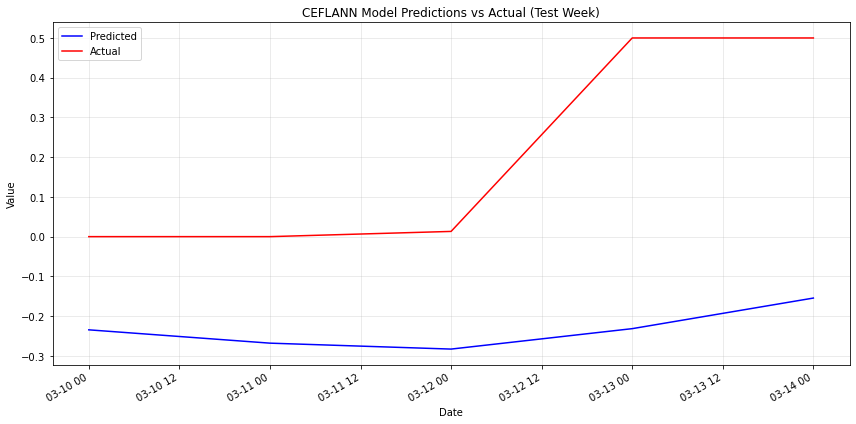

C:\Users\sorou\AppData\Local\Temp\ipykernel_12864\2621682149.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


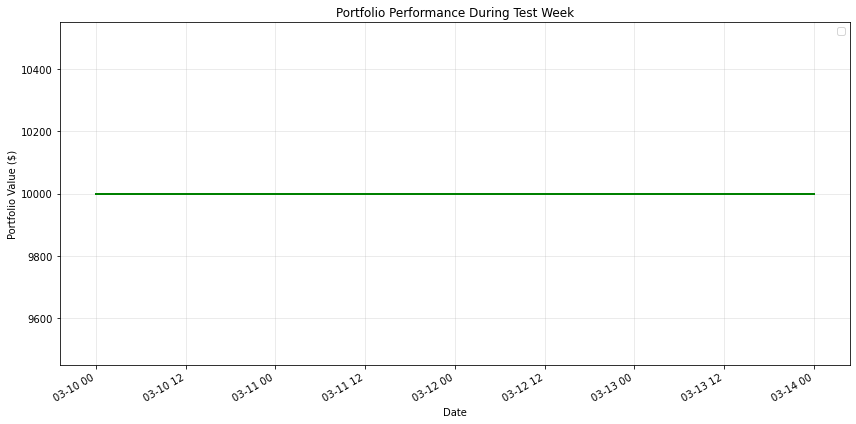

===== TRADING SUMMARY =====
Initial Portfolio: $10000.00
Final Portfolio: $10000.00
Profits/Losses: $0.00 (0.00%)
Total Transaction Fees: $0.00
Number of Buys: 0
Number of Sells: 0

===== MODEL PERFORMANCE =====
MSE: 0.2356
RMSE: 0.4854
R²: -2.9955
MAE: 0.4370
Training Time: 0.0020 seconds

===== DAILY ORDERS =====
Day 1: Hold
Day 2: Hold
Day 3: Hold
Day 4: Hold
Day 5: Hold


In [75]:
def run_simulation_on_test_week(nvidia_data, week_index=-1):
    """
    Run a complete simulation on a test week
    References functions in cells [11], [12], [13], and [14]
    
    Parameters:
        nvidia_data : Loaded NVIDIA data
        week_index : Index of the test week to use (-1 for most recent)
    
    Returns:
        results : Results of the pipeline run
    """
    # Get training data
    X_train = nvidia_data['X_train']
    y_train = nvidia_data['y_train']
    
    # Get test week data
    if week_index < 0 or week_index >= len(nvidia_data['test_weeks']):
        # Use the most recent week
        test_week = nvidia_data['test_weeks'][-1]
    else:
        test_week = nvidia_data['test_weeks'][week_index]
    
    X_test = test_week['X']
    y_test = test_week['y']
    test_dates = test_week['dates']
    
    # Extract prices from the test week
    if 'price_data' in test_week and test_week['price_data'] is not None:
        test_prices = test_week['price_data']
    else:
        # If price data not available, use the latest close price
        test_prices = np.full(len(X_test), nvidia_data['latest_close'])
    
    # Run the trading pipeline
    results = run_trading_pipeline(
        X_train, y_train, X_test, y_test, test_prices, test_dates,
        expansion_order=5, regularization=0.01
    )
    
    # Visualize results
    plot_predictions_vs_actual(
        results['predictions'], y_test, test_dates,
        "CEFLANN Model Predictions vs Actual (Test Week)"
    )
    
    plot_portfolio_performance(
        results['simulation_results'], test_dates,
        "Portfolio Performance During Test Week"
    )
    
    display_trading_summary(results)
    
    return results

# Run simulation on the most recent test week
if nvidia_data['test_weeks']:
    print("Running simulation on the most recent test week...")
    results = run_simulation_on_test_week(nvidia_data)
else:
    print("No test weeks available. Please ensure the data is properly loaded.")